In [ ]:
import json
from pandas import json_normalize
import re
import pandas as pd
from hazm import Normalizer, word_tokenize, Stemmer, Lemmatizer, stopwords_list
import arabic_reshaper
from bidi.algorithm import get_display
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import Counter
from nltk.util import ngrams
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px
from lancedb.embeddings import EmbeddingFunction
from FlagEmbedding import BGEM3FlagModel
from pydantic import PrivateAttr
import lancedb
from pydantic import Field
from typing import Annotated
import numpy as np
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry

## 1. Preprocessing

In [68]:
with open('PerCQA_JSON_Format.json', 'r', encoding='utf-8-sig') as f:
    data = json.load(f)

df = json_normalize(data)
df.head()

QID QCATEGORY                QDATE  QUSERID    QTYPE        QGOLD_YN  \
0  1550088      None  2018-01-01T12:14:00     9101  General  Not Applicable   
1  1558609      None  2018-01-06T00:17:00     6856  General  Not Applicable   
2  1587820      None  2018-01-22T13:23:00     9918  General  Not Applicable   
3  4414921      None  2020-05-23T02:06:00    81403  General  Not Applicable   
4  3109668      None  2019-08-13T12:07:00    25700  General  Not Applicable   

    QUsername                                              QBody  \
0    sami1366  ÿØŸàÿ≥ÿ™ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØŸÖ (ÿ¥ŸàŸáÿ±ŸÖ)ÿ®ÿßŸáÿßŸÖ ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸàŸÑÿØÿ¥Ÿá ⁄Ü...   
1  khanoomi72  ŸÖŸÜ ÿÆŸàÿØŸÖ ÿ≠ÿ≥ ŸÖ€å⁄©ŸÜŸÖ ÿßÿ¥ÿ™ÿ®ÿßŸáŸÖ ⁄Ø€åÿ± ÿØÿßÿØŸÜ ÿ®€åÿÆŸàÿØ€å Ÿà ÿ∫ÿ± ...   
2         lol  ÿ≥ÿßŸÑ⁄Øÿ±ÿØ ÿßÿ≤ÿØŸàÿßÿ¨ŸÖ ŸÜÿ≤ÿØ€å⁄©Ÿá ⁄Ü€å ÿ®ÿÆÿ±ŸÖ. ÿ≥ÿßŸÑ⁄Øÿ±ÿØ ÿØŸàŸÖŸÖŸàŸÜŸá....   
3  sepide1400  ÿØÿÆÿ™ÿ± ŸÖŸÜ ⁄ÜŸáÿßÿ±ÿØŸá ŸÖÿßŸáŸá ÿßÿ≥ÿ™. ÿ¢€åÿß ÿ®ÿ±ÿß€å ÿ™ÿ¥ÿÆ€åÿµ Ÿæÿ±ÿßŸÜÿ™ÿ≤...   
4       ŸÜÿ≥ÿß€∑€π   ⁄ÜŸá ŸæŸÖÿßÿØ€å ÿ®ÿ≤ŸÜŸÖ Ÿà ÿßÿ≤ ⁄Ü€åŸá ÿß€åŸÜÿ¨Ÿàÿ± ÿ¥ÿØŸá  . Ÿàÿßÿ∂ÿ≠ ŸÜ€åÿ≥...   

                                    QSubject  \
0                                 ŸÇŸáÿ± ÿ¥ŸàŸáÿ±ŸÖ    
1  ÿ®ÿ≤ÿ±⁄Øÿ™ÿ±€åŸÜ ÿßÿ¥ÿ™ÿ®ÿßŸá ÿØŸàÿ±ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØ€åÿ™ŸàŸÜ ⁄Ü€å ÿ®ŸàÿØŸáÿüÿü   
2                  ⁄©ŸÖ⁄© ÿ≥ÿßŸÑ⁄Øÿ±ÿØ ÿßÿ≤ÿØŸàÿßÿ¨ŸÖ ŸÜÿ≤ÿØ€å⁄©Ÿá   
3        ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ÿ™ŸàŸæÿØ€å ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ Ÿæÿ±ÿßŸÜÿ™ÿ≤€å Ÿæÿß   
4                      ŸÑŸæ Ÿæÿ≥ÿ±ŸÖ ŸÇÿ±ŸÖÿ≤ ÿØŸàŸÜ ÿØŸàŸÜŸá   

                                            Comments  
0  [{'CID': '50758322', 'CUSERID': 4918, 'CGOLD':...  
1  [{'CID': '51114707', 'CUSERID': 3935, 'CGOLD':...  
2  [{'CID': '52336355', 'CUSERID': 10255, 'CGOLD'...  
3  [{'CID': '138006316', 'CUSERID': 38437, 'CGOLD...  
4  [{'CID': '100859930', 'CUSERID': 33391, 'CGOLD...

In [69]:
normalizer = Normalizer()
stemmer = Stemmer()
lemmatizer = Lemmatizer()
stopwords = set(stopwords_list())

slang_dict = {
    "ÿÆÿÆÿÆ": "ÿÆŸÜÿØŸá",
    "ŸáŸáŸá": "ÿÆŸÜÿØŸá",
    "ŸáŸáŸáŸáŸá": "ÿÆŸÜÿØŸá",
    "ÿπŸá": "ÿ™ÿπÿ¨ÿ®",
    "ÿπŸáŸáŸá": "ÿ™ÿπÿ¨ÿ®",
    "ŸÖÿ±ÿ≥€å": "ŸÖŸÖŸÜŸàŸÜ",
    "ÿØŸÖÿ™": "ÿ™ÿ¥⁄©ÿ±",
    "ÿ®ÿßÿ≠ÿßŸÑ": "ÿ¨ÿßŸÑÿ®",
    "ÿßŸà⁄©€å": "ÿ®ÿßÿ¥Ÿá",
}

def preprocess_text(text, replace_slang=True):
    if not isinstance(text, str):
        return text
    
    text = text.replace("Ÿä", "€å").replace("ŸÉ", "⁄©")
    
    diacritics_pattern = re.compile(r'[\u064B-\u0652]')
    text = re.sub(diacritics_pattern, '', text)
    
    text = normalizer.normalize(text)
    
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    
    if replace_slang:
        for slang, standard in slang_dict.items():
            text = re.sub(rf"\b{slang}\b", standard, text)
    
    text = re.sub(r'[ÿü.!]', '', text)
    
    tokens = word_tokenize(text)
    
    tokens = [tok for tok in tokens if tok not in stopwords]
    
    tokens = [lemmatizer.lemmatize(stemmer.stem(tok)) for tok in tokens]
    
    return " ".join(tokens)

df["QBody_clean"] = df["QBody"].apply(preprocess_text)
df


QID QCATEGORY                QDATE  QUSERID    QTYPE        QGOLD_YN  \
0    1550088      None  2018-01-01T12:14:00     9101  General  Not Applicable   
1    1558609      None  2018-01-06T00:17:00     6856  General  Not Applicable   
2    1587820      None  2018-01-22T13:23:00     9918  General  Not Applicable   
3    4414921      None  2020-05-23T02:06:00    81403  General  Not Applicable   
4    3109668      None  2019-08-13T12:07:00    25700  General  Not Applicable   
..       ...       ...                  ...      ...      ...             ...   
985  1582862      None  2018-01-19T14:50:00     9379  General  Not Applicable   
986  1790522      None  2018-05-20T00:46:00    12482  General  Not Applicable   
987  1574016      None  2018-01-14T11:51:00     9753  General  Not Applicable   
988  4171615      None  2020-04-06T18:17:00    30885  General  Not Applicable   
989  1571432      None  2018-01-12T22:59:00     4390  General  Not Applicable   

            QUsername                                              QBody  \
0            sami1366  ÿØŸàÿ≥ÿ™ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØŸÖ (ÿ¥ŸàŸáÿ±ŸÖ)ÿ®ÿßŸáÿßŸÖ ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸàŸÑÿØÿ¥Ÿá ⁄Ü...   
1          khanoomi72  ŸÖŸÜ ÿÆŸàÿØŸÖ ÿ≠ÿ≥ ŸÖ€å⁄©ŸÜŸÖ ÿßÿ¥ÿ™ÿ®ÿßŸáŸÖ ⁄Ø€åÿ± ÿØÿßÿØŸÜ ÿ®€åÿÆŸàÿØ€å Ÿà ÿ∫ÿ± ...   
2                 lol  ÿ≥ÿßŸÑ⁄Øÿ±ÿØ ÿßÿ≤ÿØŸàÿßÿ¨ŸÖ ŸÜÿ≤ÿØ€å⁄©Ÿá ⁄Ü€å ÿ®ÿÆÿ±ŸÖ. ÿ≥ÿßŸÑ⁄Øÿ±ÿØ ÿØŸàŸÖŸÖŸàŸÜŸá....   
3          sepide1400  ÿØÿÆÿ™ÿ± ŸÖŸÜ ⁄ÜŸáÿßÿ±ÿØŸá ŸÖÿßŸáŸá ÿßÿ≥ÿ™. ÿ¢€åÿß ÿ®ÿ±ÿß€å ÿ™ÿ¥ÿÆ€åÿµ Ÿæÿ±ÿßŸÜÿ™ÿ≤...   
4               ŸÜÿ≥ÿß€∑€π   ⁄ÜŸá ŸæŸÖÿßÿØ€å ÿ®ÿ≤ŸÜŸÖ Ÿà ÿßÿ≤ ⁄Ü€åŸá ÿß€åŸÜÿ¨Ÿàÿ± ÿ¥ÿØŸá  . Ÿàÿßÿ∂ÿ≠ ŸÜ€åÿ≥...   
..                ...                                                ...   
985  ŸÖÿßŸÖÿßŸÜ_ŸÖŸáÿ±ÿßÿØ_ÿ¨ŸàŸÜ€å  ŸáÿØÿß€åÿß€å€å ⁄©Ÿá ÿ®ÿ±ÿß€å ÿ®ŸÑŸá ÿ®ÿ±ŸàŸÜ ŸÖ€å ÿ®ÿ±ŸÜ ÿ™Ÿà ÿ¥Ÿáÿ±Ÿáÿß€å ŸÖÿÆÿ™ŸÑ...   
986         _ŸÖŸáÿ±ÿ®ÿßŸÜŸà_  ÿ®ÿ±ÿßŸä ÿßŸàŸÑŸäŸÜ ÿ®ÿßÿ± ŸÉÿ±Ÿá Ÿä ÿ®ÿßÿØŸàŸÖ ÿ≤ŸÖŸäŸÜŸä ÿÆÿ±ŸäÿØŸÖ ŸàŸÑŸä ŸÜŸÖŸä...   
987           ŸÖÿßÿ±ÿßŸÑÿßŸÜ  ŸÖŸÜ €πŸÖÿßŸáŸá ⁄©Ÿá ÿπŸÇÿØ ⁄©ÿ±ÿØŸÖ . ŸÜÿßŸÖÿ≤ÿØŸÖ ŸÖÿßŸá€å€±€±€∞€∞ÿ≠ŸÇŸàŸÇÿ¥Ÿá ÿ™...   
988          saghiiii  ÿ®⁄ÜŸá Ÿáÿß ÿßÿ≤ ⁄©€å ÿ®Ÿá ŸÜÿ®ŸàÿØŸÜ ÿ¥€åÿ± ÿπÿßÿØÿ™ ŸÖ€å⁄©ŸÜŸÜÿü €≥ ÿ±Ÿàÿ≤Ÿá ⁄Ø...   
989           reza_gh  ÿ≥ŸÑÿßŸÖ ÿÆÿØŸÖÿ™ ⁄©ÿßÿ±ÿ®ÿ±ÿßŸÜ ŸÖÿ≠ÿ™ÿ±ŸÖ. ŸÖŸÜ ŸÇÿµÿØ ÿØÿßÿ±ŸÖ ÿ®Ÿá ÿÆŸàÿßÿ≥ÿ™⁄Ø...   

                                              QSubject  \
0                                           ŸÇŸáÿ± ÿ¥ŸàŸáÿ±ŸÖ    
1            ÿ®ÿ≤ÿ±⁄Øÿ™ÿ±€åŸÜ ÿßÿ¥ÿ™ÿ®ÿßŸá ÿØŸàÿ±ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØ€åÿ™ŸàŸÜ ⁄Ü€å ÿ®ŸàÿØŸáÿüÿü   
2                            ⁄©ŸÖ⁄© ÿ≥ÿßŸÑ⁄Øÿ±ÿØ ÿßÿ≤ÿØŸàÿßÿ¨ŸÖ ŸÜÿ≤ÿØ€å⁄©Ÿá   
3                  ŸÖÿ™ÿÆÿµÿµ ÿßÿ±ÿ™ŸàŸæÿØ€å ÿ®ÿ±ÿß€å ÿØÿ±ŸÖÿßŸÜ Ÿæÿ±ÿßŸÜÿ™ÿ≤€å Ÿæÿß   
4                                ŸÑŸæ Ÿæÿ≥ÿ±ŸÖ ŸÇÿ±ŸÖÿ≤ ÿØŸàŸÜ ÿØŸàŸÜŸá   
..                                                 ...   
985  ÿ®ŸÑŸá ÿ®ÿ±ŸàŸÜ. ÿÆÿßŸÜŸÖÿß€å ŸÖ€åÿ¥Ÿá ÿ®⁄Ø€åÿØ ÿ®ÿ±ÿß€å ÿ®ŸÑŸá ÿ®ÿ±ÿßŸÜ ⁄ÜŸá ⁄Ü€å...   
986                  ÿ®ÿß ŸÉÿ±Ÿá Ÿä ÿ®ÿßÿØŸàŸÖ ÿ≤ŸÖŸäŸÜŸä ⁄ÜŸä ÿØÿ±ÿ≥ÿ™ ŸÉŸÜŸÖÿü   
987                                             ŸÜÿßŸÖÿ≤ÿØ€å   
988                                  ÿßÿ≤ ÿ¥€åÿ± ⁄Øÿ±ŸÅÿ™ŸÜ ⁄©ŸàÿØ⁄©   
989                           ŸÜÿ≠ŸàŸá ŸÖÿ∑ÿ±ÿ≠ ⁄©ÿ±ÿØŸÜ ÿÆŸàÿßÿ≥ÿ™⁄Øÿßÿ±€å   

                                              Comments  \
0    [{'CID': '50758322', 'CUSERID': 4918, 'CGOLD':...   
1    [{'CID': '51114707', 'CUSERID': 3935, 'CGOLD':...   
2    [{'CID': '52336355', 'CUSERID': 10255, 'CGOLD'...   
3    [{'CID': '138006316', 'CUSERID': 38437, 'CGOLD...   
4    [{'CID': '100859930', 'CUSERID': 33391, 'CGOLD...   
..                                                 ...   
985  [{'CID': '52145320', 'CUSERID': 10177, 'CGOLD'...   
986  [{'CID': '59550231', 'CUSERID': 13736, 'CGOLD'...   
987  [{'CID': '51780636', 'CUSERID': 9563, 'CGOLD':...   
988  [{'CID': '131471418', 'CUSERID': 6245, 'CGOLD'...   
989  [{'CID': '51675328', 'CUSERID': 9609, 'CGOLD':...   

                                           QBody_clean  
0    ÿØŸàÿ≥ ŸÜÿßŸÖÿ≤ÿØ ( ÿ¥ŸàŸáÿ± ) ÿ®ÿß ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿà

In [70]:
text = "ŸÖŸÖŸÜŸàŸÜ ÿßÿ≤ ÿ¥ŸÖÿß"
reshaped_text = arabic_reshaper.reshape(text)

bidi_text = get_display(reshaped_text)

print("Before:", text)
print("After:", bidi_text)


Before: ŸÖŸÖŸÜŸàŸÜ ÿßÿ≤ ÿ¥ŸÖÿß
After: Ô∫éÔª§Ô∫∑ Ô∫ØÔ∫ç Ôª•ÔªÆÔª®Ôª§Ôª£


In [71]:
df.columns

Index(['QID', 'QCATEGORY', 'QDATE', 'QUSERID', 'QTYPE', 'QGOLD_YN',
       'QUsername', 'QBody', 'QSubject', 'Comments', 'QBody_clean'],
      dtype='object')

## 2. EDA

In [72]:
def extract_cbodies(comments):
    if isinstance(comments, list): 
        return [c.get("CBody", "") for c in comments if isinstance(c, dict)]
    elif isinstance(comments, dict): 
        return [comments.get("CBody", "")]
    else:
        return []

df["Comments_CBody"] = df["Comments"].apply(extract_cbodies)

for i, row in df[['QBody', 'Comments_CBody']].head(2).iterrows():
    print(f"Question {i+1}: {row['QBody']}")
    print("Answers:")
    for j, ans in enumerate(row['Comments_CBody'], 1):
        print(f"  {j}. {ans}")
    print("-"*80)


Question 1: ÿØŸàÿ≥ÿ™ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØŸÖ (ÿ¥ŸàŸáÿ±ŸÖ)ÿ®ÿßŸáÿßŸÖ ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸàŸÑÿØÿ¥Ÿá ⁄ÜŸá ⁄©ŸÜŸÖÿüŸÖŸàÿ∂Ÿàÿπ ÿØÿπŸàÿßŸÖŸàŸÜ ⁄Ü€åÿ≤€å ÿ®ŸàÿØŸá ⁄©Ÿá ŸÖŸÜ ŸÖŸÇÿµÿ±ÿ¥ ŸÜ€åÿ≥ÿ™ŸÖ...ÿÆŸàÿØÿ¥ŸÖ ŸÖ€åÿØŸàŸÜŸá ÿ±ÿ®ÿ∑€å ÿ®Ÿá ŸÖŸÜ ŸÜÿØÿßÿ±Ÿá
Answers:
  1. ŸÇŸáÿ± ÿ¨ÿØÿß ÿ™ŸàŸÑÿØ ÿ¨ÿØÿß. ÿ∂ŸÖŸÜÿß ÿÆŸàÿßŸáÿ±ÿßŸÜŸá ŸÖ€å⁄ØŸÖ ÿß€åŸÜ ŸÇŸáÿ± Ÿà ŸáŸÖ€åŸÜ ÿßÿ®ÿ™ÿØÿß€å ÿ≤ŸÜÿØ⁄Ø€åÿ™ ŸÖÿ≠Ÿàÿ¥ ⁄©ŸÜ ÿπÿ≤€åÿ≤ŸÖ
  2. ÿßŸÜŸÇÿØÿ± ÿ™ÿ≠ŸàŸäŸÑÿ¥ ŸÜ⁄ØŸäÿ± ÿ™ÿß ÿÆŸàÿØÿ¥ ÿ®ŸäÿßÿØ ÿ≥ŸÖÿ™ÿ™ÿåÿßŸäŸÜ ÿ¨Ÿàÿ±Ÿä ÿßÿØÿ® ŸÖŸä ÿ¥Ÿá ŸÉŸá ÿØŸä⁄ØŸá ŸÇŸáÿ± ŸÜŸÉŸÜŸá.. ÿßŸÑÿ®ÿ™Ÿá ÿß⁄Øÿ± ÿ∑ÿßŸÇÿ™ ŸÖŸäÿßÿ±Ÿä ŸÉŸá ÿ®Ÿáÿ¥ ÿ≤ŸÜ⁄Ø ŸÜÿ≤ŸÜŸä ÿßŸäŸÜŸÉÿßÿ±Ÿä ŸÉŸá ⁄ØŸÅÿ™ŸÖ ÿ±Ÿà ÿßŸÜÿ¨ÿßŸÖ ÿ®ÿØŸä ÿ®Ÿáÿ™ÿ±Ÿê ÿπÿ≤Ÿäÿ≤ŸÖ.
  3. ÿ™ŸàŸÑÿØ ÿ®ÿ±ÿßÿ¥ ÿ®⁄ØŸäÿ±. ŸÇŸáÿ± ÿ¨ÿØÿßÿ≥
  4. ÿ™ŸàŸÑÿØÿ¥ŸàŸÜ ÿ±Ÿà ÿ™ÿ®ÿ±€å⁄© ÿ®⁄Ø€åŸÜ . ÿ¨Ÿàÿ±€å ⁄©Ÿá ÿßÿ≠ÿ≥ÿßÿ≥ ŸÜ⁄©ŸÜŸÜ ÿØÿßÿ±€åŸÜ ŸÖŸÜÿ™ ⁄©ÿ¥€å ŸÖ€å⁄©ŸÜ€åŸÜ . €åÿπŸÜ€å ŸÜÿ¥ŸàŸÜ ÿ®ÿØ€åŸÜ ÿØŸÑÿÆŸàÿ±€åŸÜ . ÿ®ÿ±ÿß ÿß€åŸÜ ŸÖ€å⁄ØŸÖ ÿ™ÿ®ÿ±€å⁄© ÿ®⁄Ø€åŸÜ ÿ™ÿß ÿ®ÿπÿØÿßÿß ÿ≠ÿ±ŸÅ ÿ®ÿ±ÿß ⁄ØŸÅÿ™ŸÜ ŸÜÿØÿßÿ¥ÿ™Ÿá ÿ®ÿßÿ¥ŸÜ .
  5. ÿ™

In [73]:
def extract_cbodies(comments):
    if isinstance(comments, list):
        return [c.get("CBody", "") for c in comments if isinstance(c, dict)]
    elif isinstance(comments, dict):
        return [comments.get("CBody", "")]
    else:
        return []

df["Comments_CBody"] = df["Comments"].apply(extract_cbodies)

answers = [ans for sublist in df["Comments_CBody"] for ans in sublist]
answers_df = pd.DataFrame({"Answer": answers})

df["Q_char_len"] = df["QBody"].astype(str).apply(len)
df["Q_word_len"] = df["QBody"].astype(str).apply(lambda x: len(x.split()))

answers_df["A_char_len"] = answers_df["Answer"].astype(str).apply(len)
answers_df["A_word_len"] = answers_df["Answer"].astype(str).apply(lambda x: len(x.split()))

print("Questions:")
print(" Avg chars:", df["Q_char_len"].mean())
print(" Median chars:", df["Q_char_len"].median())
print(" Avg words:", df["Q_word_len"].mean())
print(" Median words:", df["Q_word_len"].median())

print("\nAnswers:")
print(" Avg chars:", answers_df["A_char_len"].mean())
print(" Median chars:", answers_df["A_char_len"].median())
print(" Avg words:", answers_df["A_word_len"].mean())
print(" Median words:", answers_df["A_word_len"].median())


fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        "Histogram - Question Word Lengths",
        "Histogram - Answer Word Lengths",
        "Boxplot - Question Character Lengths",
        "Boxplot - Answer Character Lengths"
    )
)

fig.add_trace(
    go.Histogram(x=df["Q_word_len"], nbinsx=50, name="Questions", marker_color='blue'),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=answers_df["A_word_len"], nbinsx=50, name="Answers", marker_color='green'),
    row=1, col=2
)

fig.add_trace(
    go.Box(x=df["Q_char_len"], name="Questions", marker_color='blue', boxmean=True),
    row=2, col=1
)

fig.add_trace(
    go.Box(x=answers_df["A_char_len"], name="Answers", marker_color='green', boxmean=True),
    row=2, col=2
)

fig.update_layout(
    height=700, width=900,
    title_text="Questions and Answers Length Analysis",
    showlegend=False
)

fig.show()



Questions:
 Avg chars: 172.93232323232323
 Median chars: 129.0
 Avg words: 35.1030303030303
 Median words: 26.0

Answers:
 Avg chars: 97.23833348494496
 Median chars: 67.0
 Avg words: 19.288592740835078
 Median words: 13.0


In [74]:
df["num_answers"] = df["Comments_CBody"].apply(len)

most_engaging = df.sort_values(by="num_answers", ascending=False)

print("Top 10 Most Engaging Questions:")
most_engaging[["QID", "QBody", "num_answers"]].head(10)


Top 10 Most Engaging Questions:


QID                                              QBody  num_answers
571  1556257  ÿ®ÿß Ÿ°Ÿ• ÿ™ŸàŸÖŸÜ ⁄ÜŸá ⁄ÜŸäÿ≤ÿßŸä ÿßÿ≤ ÿ¨Ÿáÿßÿ≤ Ÿà ŸÖŸäÿ¥Ÿá ÿÆÿ±ŸäÿØ ÿü! ŸÉŸá ...          315
152  1577970  ⁄©ÿ≥€å ÿßÿ∑ŸÑÿßÿπ ÿØÿßÿ±Ÿá ÿ®ÿÆŸàÿßÿ®ŸÖ Ÿæ€åÿ¥ ÿß€åÿ¥ŸàŸÜ ÿ®ÿ±ŸäŸÖ ⁄Üÿ∑Ÿàÿ±€å Ÿà ⁄©...          313
342  1559359  ÿ®ÿπÿØ ÿ∑ŸÑÿßŸÇ ⁄Üÿ∑Ÿàÿ± ÿÆŸàÿØÿ™ŸàŸÜŸà ÿ≥ÿ±Ÿæÿß ŸÜ⁄ØŸá ÿØÿßÿ¥ÿ™€åŸÜ. ⁄Üÿ∑Ÿàÿ± ÿÆŸà...          215
728  1555428  ŸÖŸÜ €åŸá ÿ≥ÿßŸÑ ŸÜÿßŸÖÿ≤ÿØ ⁄©ÿ±ÿØŸÖ ŸÇÿ±ÿßÿ± €åŸá ÿ≥ÿßŸÑ ÿØ€å⁄ØŸá ŸáŸÖ ŸÜÿßŸÖÿ≤ÿØ...          215
194  1578477  ÿ®€åÿß€åŸÜ ÿ®⁄Ø€åŸÜ ⁄Ü€å⁄©ÿßÿ± ŸÖ€å⁄©ŸÜ€åŸÜ ŸÜÿßÿ≤ÿ™ŸàŸÜŸà ŸÖ€å⁄©ÿ¥Ÿáÿü. ŸÖŸÜ ÿ¥ŸàŸá...          166
969  1569562  ŸÖÿß ÿπŸÇÿØ Ÿáÿ≥ÿ™€åŸÖ.ÿ¥ŸàŸáÿ±ŸÖ ÿßÿµŸÑÿß ÿÆÿ≥€åÿ≥ ŸÜ€åÿ≥ÿ™ Ÿáÿ± ⁄Ü€å ÿ®ÿÆŸàÿßŸÖ ...          144
256  1591164  ÿ¥ŸàŸáÿ±ÿ™ŸàŸÜ ŸÖÿßÿ¥€åŸÜ ÿ¨ÿØ€åÿØ ÿ®ÿÆÿ±Ÿá ŸÜÿßÿ±ÿßÿ≠ÿ™ ŸÖ€åÿ¥€åÿØ ÿ®Ÿá ŸÜÿßŸÖ ÿ¥ŸÖ...          143
628  1585904  ÿßÿ≥ÿ™ÿÆÿßÿ±Ÿá ÿ≤ÿØŸÖ ÿ®ÿØ ÿßŸàŸÖÿØ ÿ™ÿ±ÿ≥€åÿØŸÖ ŸàÿßŸÇÿπÿß ÿßÿ≤ ÿß€åŸÜ⁄©Ÿá ÿßŸÑÿßŸÜ...          137
677  1567278  ÿ≥ŸÑÿßŸÖ ÿØŸàÿ≥ÿ™ÿßŸÜ ⁄ÜŸÜÿØ ÿ±Ÿàÿ≤ ÿ¢€åŸÜÿØŸá ŸÇÿ±ÿßÿ±Ÿá Ÿàÿßÿ≥ŸÖ ÿÆŸàÿßÿ≥ÿ™⁄Øÿßÿ± ...          137
8    1575297  ÿ¥ŸàŸáÿ±ŸÖ ŸáŸÖÿ¥ ÿ®ŸáÿßŸÜŸá ŸÖ€å⁄Ø€åÿ±Ÿá ŸáŸÖÿ¥ ÿØÿπŸàÿß.ŸÖ€å⁄ØŸá ÿ™ŸàŸá€å⁄Ü€å ÿ®Ÿá...          136

In [75]:
total_questions = df.shape[0]
questions_with_answers = (df["num_answers"] > 0).sum()
questions_without_answers = total_questions - questions_with_answers

print(f"Total questions: {total_questions}")
print(f"Questions with at least one answer: {questions_with_answers}")
print(f"Questions without answers: {questions_without_answers}")
print(f"Average number of answers per question: {round(df['num_answers'].mean()):.2f}")
print(f"Median number of answers per question: {df['num_answers'].median()}")


Total questions: 990
Questions with at least one answer: 990
Questions without answers: 0
Average number of answers per question: 22.00
Median number of answers per question: 15.0


In [209]:
all_comments = []
for _, row in df.iterrows():
    qid = row['QID']
    for c in row['Comments']:
        if isinstance(c, dict) and 'CDate' in c:
            all_comments.append({
                'QID': qid,
                'CBody': c.get('CBody', ''),
                'CDate': c['CDate']
            })

comments_df = pd.DataFrame(all_comments)

comments_df['CDate'] = pd.to_datetime(comments_df['CDate'])


In [210]:
comments_df['hour'] = comments_df['CDate'].dt.hour
comments_df['day_of_week'] = comments_df['CDate'].dt.day_name()

hourly_activity = comments_df.groupby('hour').size().reset_index(name='count')

daily_activity = comments_df.groupby('day_of_week').size().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
).reset_index(name='count')


In [211]:
fig_hour = px.bar(hourly_activity, x='hour', y='count', 
                  title='User Activity by Hour',
                  labels={'count':'Number of Comments', 'hour':'Hour of Day'},
                  color='count')
fig_hour.show()

fig_day = px.bar(daily_activity, x='day_of_week', y='count',
                 title='User Activity by Day of Week',
                 labels={'count':'Number of Comments', 'day_of_week':'Day'},
                 color='count')
fig_day.show()


In [212]:
heatmap_data = comments_df.pivot_table(
    index=comments_df['day_of_week'],
    columns=comments_df['hour'],
    values='CBody',
    aggfunc='count'
).reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

fig_heat = px.imshow(heatmap_data,
                     labels=dict(x="Hour", y="Day of Week", color="Number of Comments"),
                     x=list(range(24)),
                     y=heatmap_data.index,
                     aspect="auto",
                     color_continuous_scale='Viridis')
fig_heat.update_layout(title="Heatmap of User Activity (Day vs Hour)")
fig_heat.show()


In [213]:
all_comments = []
for _, row in df.iterrows():
    for c in row['Comments']:
        if isinstance(c, dict):
            all_comments.append({
                'QID': row['QID'],
                'CUsername': c.get('CUsername', 'Unknown'),
                'CBody': c.get('CBody', ''),
                'CDate': c.get('CDate', None)
            })

comments_df = pd.DataFrame(all_comments)


In [214]:
user_counts = comments_df.groupby('CUsername').size().reset_index(name='num_answers')

top_users = user_counts.sort_values(by='num_answers', ascending=False).head(10)
top_users


CUsername  num_answers
3200    ÿ®ÿßÿ±ÿßŸÜ_ÿ®Ÿáÿßÿ±€å95          142
3280       ÿ®ŸÑŸàÿ®ÿ±€å€≥€≤€≥€∑           96
376           a_rezoo           93
2249         saghiiii           89
4551         ÿπÿ≥ŸÑ€åk516           86
159         69_fahime           84
4845          ŸÖÿßÿ±ÿßŸÑÿßŸÜ           82
4654          ŸÅÿ±ÿ≤ÿßŸÜ11           82
2990  ÿßÿ±ÿØ€åÿ®Ÿáÿ¥ÿ™_ÿ±Ÿà€åÿß€å€å           81
867                es           75

In [82]:
fig = px.bar(top_users, x='CUsername', y='num_answers',
             title='Top 10 Answer Contributors',
             labels={'num_answers':'Number of Answers', 'CUsername':'User'},
             text='num_answers',
             color='num_answers',
             color_continuous_scale='Viridis')

fig.update_traces(textposition='outside')
fig.update_layout(xaxis_tickangle=-45)
fig.show()


In [ ]:
normalizer = Normalizer()
persian_stopwords = set(stopwords_list())

persian_punctuations = set("ÿåÿõÿü¬´¬ª‚Ä¶Ÿ™Ÿ´()[]{}!ÿü:ÿõÿå.ÿü\"'\\/|@#$%^&*-+=~`")

filter_tokens = persian_stopwords.union(persian_punctuations)

all_questions = " ".join(df['QBody'].astype(str))
all_answers = " ".join([ans for sublist in df['Comments_CBody'] for ans in sublist])

q_tokens = word_tokenize(normalizer.normalize(all_questions))
a_tokens = word_tokenize(normalizer.normalize(all_answers))

q_tokens_clean = [t for t in q_tokens if t not in filter_tokens and t.strip()]
a_tokens_clean = [t for t in a_tokens if t not in filter_tokens and t.strip()]

def get_top_words(tokens, top_k=20):
    return Counter(tokens).most_common(top_k)

top_q_words_before = get_top_words(q_tokens)
top_a_words_before = get_top_words(a_tokens)
top_q_words_after = get_top_words(q_tokens_clean)
top_a_words_after = get_top_words(a_tokens_clean)

print("Top Question Words (before cleaning):", top_q_words_before)
print("Top Question Words (after cleaning):", top_q_words_after)
print("Top Answer Words (before cleaning):", top_a_words_before)
print("Top Answer Words (after cleaning):", top_a_words_after)

Top Question Words (before cleaning): [('.', 1764), ('Ÿà', 1085), ('ÿü', 1051), ('⁄©Ÿá', 552), ('ÿßÿ≤', 493), ('ŸÖŸÜ', 447), ('ÿ®Ÿá', 420), ('ÿ±Ÿà', 345), ('⁄©ŸÜŸÖ', 314), ('ŸáŸÖ', 301), ('ÿÆ€åŸÑ€å', 285), ('ÿ™Ÿà', 256), ('ÿå', 249), ('ÿ®ÿß', 239), ('€åÿß', 222), ('ŸàŸÑ€å', 220), ('€åŸá', 214), ('ÿØÿßÿ±Ÿá', 214), ('Ÿáÿ≥ÿ™', 214), ('ÿ™ÿß', 199)]
Top Question Words (after cleaning): [('€åŸá', 214), ('ÿØÿßÿ±Ÿá', 214), ('Ÿáÿ≥ÿ™', 214), ('ŸÖ€åÿ¥Ÿá', 195), ('ÿ®ÿßÿ¥Ÿá', 176), ('ÿßŸÑÿßŸÜ', 170), ('⁄Ü€å', 143), ('ÿØÿÆÿ™ÿ±ŸÖ', 141), ('ŸÖ€å⁄©ŸÜŸá', 141), ('ÿ®⁄ÜŸá', 137), ('ÿ®Ÿáÿ¥', 128), ('ŸÖÿßŸáÿ¥Ÿá', 126), ('Ÿæÿ≥ÿ±ŸÖ', 124), ('⁄Ü€å⁄©ÿßÿ±', 118), ('ÿØÿßÿ±ŸÖ', 109), ('ÿ¥€åÿ±', 105), ('ÿØ⁄©ÿ™ÿ±', 105), ('ÿ®ŸáŸÖ', 101), ('ÿØ€å⁄ØŸá', 99), ('ÿ®ÿØŸÖ', 96)]
Top Answer Words (before cleaning): [('.', 28216), ('Ÿà', 9927), ('ŸÖŸÜ', 5487), ('⁄©Ÿá', 5486), ('ÿ®Ÿá', 5465), ('ÿßÿ≤', 4986), ('ŸáŸÖ', 3728), ('ÿå', 3691), ('ÿ±Ÿà', 3526), ('ÿ™Ÿà', 3166), ('ÿü', 3121), ('..', 3116), ('ÿÆ€åŸÑ€å', 3101), ('€åŸá', 3

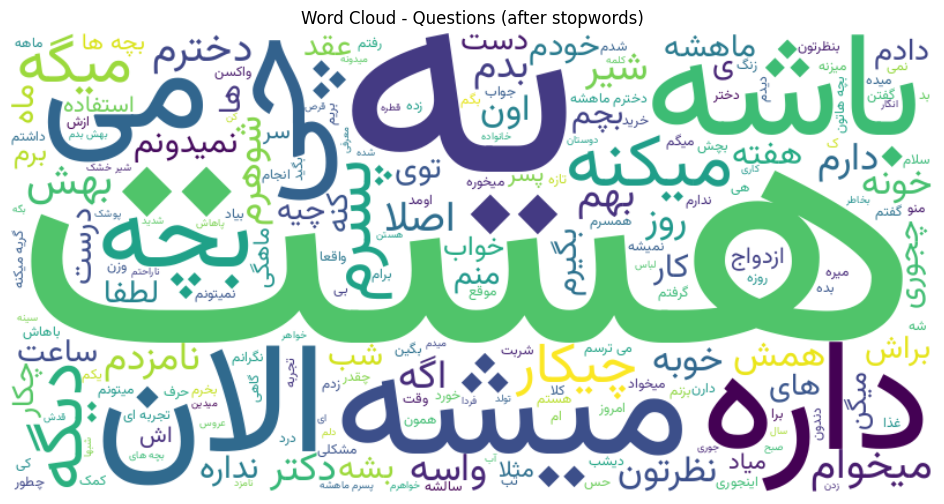

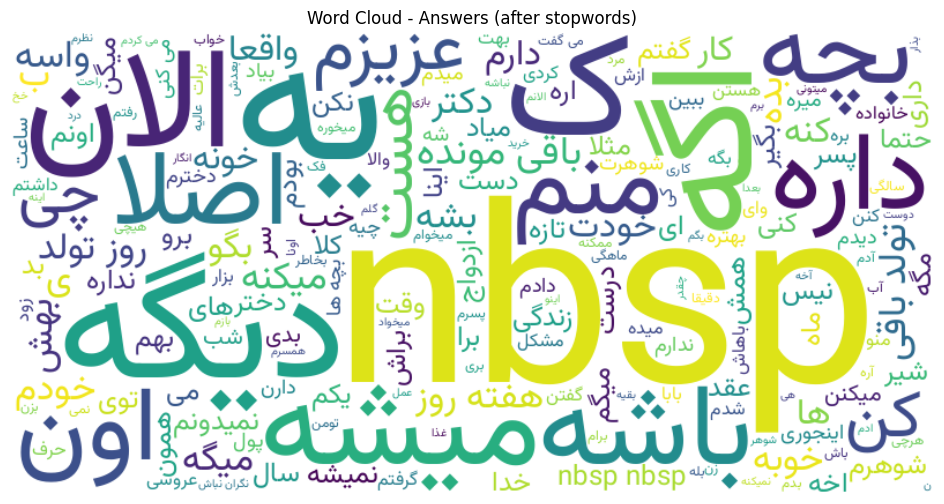

In [195]:
font_path = "Vazirmatn-Regular.ttf"

def plot_wordcloud(tokens, title):
    wc = WordCloud(width=800, height=400, background_color='white',
                   font_path=font_path).generate(" ".join(tokens))
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_wordcloud(q_tokens_clean, "Word Cloud - Questions (after stopwords)")
plot_wordcloud(a_tokens_clean, "Word Cloud - Answers (after stopwords)")


In [196]:
def get_top_ngrams(tokens, n=2, top_k=20):
    n_grams = ngrams(tokens, n)
    return Counter(n_grams).most_common(top_k)

# Unigrams
top_q_unigrams = get_top_ngrams(q_tokens_clean, 1)
top_a_unigrams = get_top_ngrams(a_tokens_clean, 1)

# Bigrams
top_q_bigrams = get_top_ngrams(q_tokens_clean, 2)
top_a_bigrams = get_top_ngrams(a_tokens_clean, 2)

# Trigrams
top_q_trigrams = get_top_ngrams(q_tokens_clean, 3)
top_a_trigrams = get_top_ngrams(a_tokens_clean, 3)


In [ ]:
def plot_top_ngrams(counter_list, title):
    ngram_str = [" ".join(tup) if isinstance(tup, tuple) else tup for tup, _ in counter_list]
    counts = [count for _, count in counter_list]
    
    fig = px.bar(
        x=ngram_str,
        y=counts,
        title=title,
        labels={'x': 'N-gram', 'y': 'Count'},
        text=counts,
        color=counts,
        color_continuous_scale='Viridis'
    )
    
    fig.update_traces(textposition='outside')
    fig.show()


plot_top_ngrams(top_q_unigrams, "Top Question Unigrams")
plot_top_ngrams(top_a_unigrams, "Top Answer Unigrams")
plot_top_ngrams(top_q_bigrams, "Top Question Bigrams")
plot_top_ngrams(top_a_bigrams, "Top Answer Bigrams")
plot_top_ngrams(top_q_trigrams, "Top Question Trigrams")
plot_top_ngrams(top_a_trigrams, "Top Answer Trigrams")


## 3. Analyse the dataset

In [87]:
from FlagEmbedding import BGEM3FlagModel

model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True)


Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

In [88]:
sample_row = df.sample(1).iloc[0]
qbody_sample = sample_row['QBody']

embedding = model.encode([qbody_sample], max_length=8192)['dense_vecs'][0]

print("QID:", sample_row['QID'])
print("Embedding length:", len(embedding))
print("First 10 dimensions:", embedding[:10])


You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


QID: 3395447
Embedding length: 1024
First 10 dimensions: [-0.01458647  0.02433824 -0.04119255  0.00146916 -0.0424397  -0.059041
  0.01560025  0.0184018   0.01571864 -0.01186331]


In [ ]:
class BgeM3EmbeddingFunction(EmbeddingFunction):
    _model: BGEM3FlagModel = PrivateAttr()
    
    def __init__(self):
        super().__init__()
        self._model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True)
    
    def compute_query_embeddings(self, queries: list) -> np.ndarray:
        embeddings = self._model.encode(queries, max_length=8192)['dense_vecs']
        return np.array(embeddings)
    
    def compute_source_embeddings(self, sources: list) -> np.ndarray:
        embeddings = self._model.encode(sources, max_length=8192)['dense_vecs']
        return np.array(embeddings)

    @property
    def ndims(self) -> int:
        return 1024  # The dimensionality of the embeddings from the bge-m3 model


In [164]:
embedding_func = get_registry().get("sentence-transformers").create()

class QuestionEntry(LanceModel):
    qid: str
    qbody: str = embedding_func.SourceField()
    embedding: Vector(embedding_func.ndims()) = embedding_func.VectorField()

db = lancedb.connect("nini_site_db")

if "questions" in db.table_names():
    db.drop_table("questions")
    print("Table 'questions' deleted successfully.")
else:
    table = db.create_table(name="questions", schema=QuestionEntry)
    print("Schema for 'questions' table created successfully.")



Schema for 'questions' table created successfully.


In [165]:
data_to_insert = []
for _, row in df.iterrows():
    data_to_insert.append({
        "qid": row['QID'],
        "qbody": row['QBody'],
    })

table.add(data_to_insert)

print("Data successfully inserted into the 'questions' table.")

Data successfully inserted into the 'questions' table.


In [179]:
table.to_pandas()

qid                                              qbody  \
0    1550088  ÿØŸàÿ≥ÿ™ÿßŸÜ ŸÜÿßŸÖÿ≤ÿØŸÖ (ÿ¥ŸàŸáÿ±ŸÖ)ÿ®ÿßŸáÿßŸÖ ŸÇŸáÿ±Ÿá ÿßŸÖÿ±Ÿàÿ≤ ÿ™ŸàŸÑÿØÿ¥Ÿá ⁄Ü...   
1    1558609  ŸÖŸÜ ÿÆŸàÿØŸÖ ÿ≠ÿ≥ ŸÖ€å⁄©ŸÜŸÖ ÿßÿ¥ÿ™ÿ®ÿßŸáŸÖ ⁄Ø€åÿ± ÿØÿßÿØŸÜ ÿ®€åÿÆŸàÿØ€å Ÿà ÿ∫ÿ± ...   
2    1587820  ÿ≥ÿßŸÑ⁄Øÿ±ÿØ ÿßÿ≤ÿØŸàÿßÿ¨ŸÖ ŸÜÿ≤ÿØ€å⁄©Ÿá ⁄Ü€å ÿ®ÿÆÿ±ŸÖ. ÿ≥ÿßŸÑ⁄Øÿ±ÿØ ÿØŸàŸÖŸÖŸàŸÜŸá....   
3    4414921  ÿØÿÆÿ™ÿ± ŸÖŸÜ ⁄ÜŸáÿßÿ±ÿØŸá ŸÖÿßŸáŸá ÿßÿ≥ÿ™. ÿ¢€åÿß ÿ®ÿ±ÿß€å ÿ™ÿ¥ÿÆ€åÿµ Ÿæÿ±ÿßŸÜÿ™ÿ≤...   
4    3109668   ⁄ÜŸá ŸæŸÖÿßÿØ€å ÿ®ÿ≤ŸÜŸÖ Ÿà ÿßÿ≤ ⁄Ü€åŸá ÿß€åŸÜÿ¨Ÿàÿ± ÿ¥ÿØŸá  . Ÿàÿßÿ∂ÿ≠ ŸÜ€åÿ≥...   
..       ...                                                ...   
985  1582862  ŸáÿØÿß€åÿß€å€å ⁄©Ÿá ÿ®ÿ±ÿß€å ÿ®ŸÑŸá ÿ®ÿ±ŸàŸÜ ŸÖ€å ÿ®ÿ±ŸÜ ÿ™Ÿà ÿ¥Ÿáÿ±Ÿáÿß€å ŸÖÿÆÿ™ŸÑ...   
986  1790522  ÿ®ÿ±ÿßŸä ÿßŸàŸÑŸäŸÜ ÿ®ÿßÿ± ŸÉÿ±Ÿá Ÿä ÿ®ÿßÿØŸàŸÖ ÿ≤ŸÖŸäŸÜŸä ÿÆÿ±ŸäÿØŸÖ ŸàŸÑŸä ŸÜŸÖŸä...   
987  1574016  ŸÖŸÜ €πŸÖÿßŸáŸá ⁄©Ÿá ÿπŸÇÿØ ⁄©ÿ±ÿØŸÖ . ŸÜÿßŸÖÿ≤ÿØŸÖ ŸÖÿßŸá€å€±€±€∞€∞ÿ≠ŸÇŸàŸÇÿ¥Ÿá ÿ™...   
988  4171615  ÿ®⁄ÜŸá Ÿáÿß ÿßÿ≤ ⁄©€å ÿ®Ÿá ŸÜÿ®ŸàÿØŸÜ ÿ¥€åÿ± ÿπÿßÿØÿ™ ŸÖ€å⁄©ŸÜŸÜÿü €≥ ÿ±Ÿàÿ≤Ÿá ⁄Ø...   
989  1571432  ÿ≥ŸÑÿßŸÖ ÿÆÿØŸÖÿ™ ⁄©ÿßÿ±ÿ®ÿ±ÿßŸÜ ŸÖÿ≠ÿ™ÿ±ŸÖ. ŸÖŸÜ ŸÇÿµÿØ ÿØÿßÿ±ŸÖ ÿ®Ÿá ÿÆŸàÿßÿ≥ÿ™⁄Ø...   

                                             embedding  
0    [-0.019125178, 0.099479295, -0.07347038, 0.004...  
1    [0.02656599, 0.02164723, -0.03400926, 0.036327...  
2    [-0.013627377, 0.053788126, -0.016664252, 0.01...  
3    [0.019605175, 0.09203873, -0.0117374845, 0.029...  
4    [-0.015349397, 0.08209522, -0.092893764, 0.027...  
..                                                 ...  
985  [0.011378793, 0.047294963, -0.062306948, -0.00...  
986  [0.011454335, 0.026831964, -0.03298005, -0.002...  
987  [0.023197755, 0.03593181, 0.0011408555, 0.0207...  
988  [0.010582658, 0.056691665, -0.05657063, -0.005...  
989  [-0.006693706, 0.017670177, 0.010162284, 0.002...  

[990 rows x 3 columns]

In [183]:
user_queries = [
    "ÿ®ÿ±ÿß€å ÿ™ÿ® ÿ®⁄ÜŸÖ ⁄Ü€å ⁄©ÿßÿ± ⁄©ŸÜŸÖÿü",
    "ÿ≥ÿ±€åÿßŸÑ Ÿà ŸÅ€åŸÑŸÖ ⁄Ü€å ÿ®ÿ®€åŸÜŸÖÿü",
    "Ÿæÿß€å ÿ®⁄ÜŸá‚ÄåÿßŸÖ Ÿæÿ±ÿßŸÜÿ™ÿ≤€åŸáÿå ÿ®ÿß€åÿØ ŸÜ⁄Øÿ±ÿßŸÜ ÿ®ÿßÿ¥ŸÖÿü",
    "ÿ≥ÿßŸÑ⁄Øÿ±ÿØ ÿßÿ≤ÿØŸàÿßÿ¨ŸÖ ⁄Ü€å ÿ®ÿÆÿ±ŸÖÿü",
    "ÿßŸàÿ™€åÿ≥ŸÖ ⁄ÜŸá ŸÜÿ¥ÿßŸÜŸá Ÿáÿß€å€å ÿØÿßÿ±ÿØÿü"
]

embedding_func = get_registry().get("sentence-transformers").create()
query_embeddings = embedding_func.compute_query_embeddings(user_queries)

for query, embedding in zip(user_queries, query_embeddings):
    print(f"\nQuery: {query}")
    results = table.search(embedding).limit(5).to_pandas()
    for i, row in results.iterrows():
        print(f"Result {i+1}: {row['qbody']}\n")


Query: ÿ®ÿ±ÿß€å ÿ™ÿ® ÿ®⁄ÜŸÖ ⁄Ü€å ⁄©ÿßÿ± ⁄©ŸÜŸÖÿü
Result 1: ⁄Üÿ∑Ÿàÿ± ÿØ⁄©ÿ™ÿ±€åŸáÿü⁄©ÿ≥€å ÿ®⁄Üÿ¥ ÿ®ÿ±ÿØŸá

Result 2: ⁄ÜŸá ⁄©ÿ≥ÿßŸÜ€å ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ⁄ÜŸÖÿ±ÿßŸÜ  ÿ≤ÿß€åŸÖÿßŸÜ ⁄©ÿ±ÿØŸÜÿü ÿ≥ÿß⁄© ÿ®ÿ±ÿß ÿ®⁄ÜŸá ÿßŸÖ ŸÖ€åÿØŸÜÿü ÿ™Ÿàÿ¥ ⁄Ü€åÿß Ÿáÿ≥ÿ™ÿü

Result 3: ÿØŸàÿ± ÿ≥ÿ± Ÿæÿ≥ÿ±ÿ®⁄ÜŸá Ÿáÿßÿ™ŸàŸÜ ÿ™Ÿà €µ ŸÖÿßŸá Ÿà ŸÜ€åŸÖ ⁄ÜŸÇÿØÿ± ÿ®ŸàÿØŸáÿü

Result 4: ⁄ÜŸá ⁄©ÿ≥ÿß€å€å ÿ®ÿß  ÿß€å Ÿà€å ÿßŸÅ  ÿ®ÿßÿ±ÿØÿßÿ± ÿ¥ÿØŸÜ ⁄Üÿ¨Ÿàÿ±€åÿü Ÿáÿ≤€åŸÜÿ¥ ⁄ÜŸÇÿØÿ± ÿ®ŸàÿØÿü

Result 5: ⁄©ÿ≥€å ÿ™ÿ¨ÿ±ÿ®Ÿá ÿØ€åÿØŸÜ ⁄ÜŸÜÿØÿ™ÿß ŸÖŸà€å ÿ≥ŸÅ€åÿØ ÿ±Ÿà€å ÿ≥ÿ± ⁄©ŸàÿØ⁄© ÿ≤€åÿ± ÿØŸàÿ≥ÿßŸÑ ÿØÿßÿ¥ÿ™Ÿáÿü


Query: ÿ≥ÿ±€åÿßŸÑ Ÿà ŸÅ€åŸÑŸÖ ⁄Ü€å ÿ®ÿ®€åŸÜŸÖÿü
Result 1: ÿ≥ÿ±€åÿßŸÑ ÿ®Ÿá ÿ¨ÿ≤ ÿØŸÑ Ÿà ⁄©ÿ±⁄ØÿØŸÜ ÿßŸÑÿßŸÜ ⁄Ü€å Ÿáÿ≥ÿ™ÿü

Result 2: ⁄Üÿ±ÿß ÿ≥ÿßŸÖÿßŸÜŸá ÿ≥ŸáÿßŸÖ ÿπÿØÿßŸÑÿ™ ÿ®ÿßŸÑÿß ŸÜŸÖ€åÿßÿØÿü

Result 3: ⁄©ÿ≥€å ÿ™ÿ¨ÿ±ÿ®Ÿá ÿØ€åÿØŸÜ ⁄ÜŸÜÿØÿ™ÿß ŸÖŸà€å ÿ≥ŸÅ€åÿØ ÿ±Ÿà€å ÿ≥ÿ± ⁄©ŸàÿØ⁄© ÿ≤€åÿ± ÿØŸàÿ≥ÿßŸÑ ÿØÿßÿ¥ÿ™Ÿáÿü

Result 4: ⁄ÜŸÜÿØ ÿØÿ±ÿ¨Ÿá ÿ±Ÿàÿ¥ŸÜ ŸÖ€å⁄©ŸÜŸá ÿü ⁄ÜŸÜÿØÿ¨ŸÑÿ≥Ÿá ÿü Ÿáÿ≤€åŸÜÿ¥ ⁄Ü€å

Result 5: ⁄ÜŸá ⁄©ÿ≥ÿßŸÜ€å ÿ®€åŸÖÿß

In [192]:
table.create_fts_index("qbody", replace=True)

for query in user_queries:
    print(f"\nQuery: {query}")
    results = table.search(query).limit(5).select(["qid", "qbody"]).to_pandas()
    for i, row in results.iterrows():
        print(f"Result {i+1}: {row['qbody']}")



Query: ÿ®ÿ±ÿß€å ÿ™ÿ® ÿ®⁄ÜŸÖ ⁄Ü€å ⁄©ÿßÿ± ⁄©ŸÜŸÖÿü
Result 1: ⁄Üÿ∑Ÿàÿ± ÿØ⁄©ÿ™ÿ±€åŸáÿü⁄©ÿ≥€å ÿ®⁄Üÿ¥ ÿ®ÿ±ÿØŸá
Result 2: ⁄ÜŸá ⁄©ÿ≥ÿßŸÜ€å ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ⁄ÜŸÖÿ±ÿßŸÜ  ÿ≤ÿß€åŸÖÿßŸÜ ⁄©ÿ±ÿØŸÜÿü ÿ≥ÿß⁄© ÿ®ÿ±ÿß ÿ®⁄ÜŸá ÿßŸÖ ŸÖ€åÿØŸÜÿü ÿ™Ÿàÿ¥ ⁄Ü€åÿß Ÿáÿ≥ÿ™ÿü
Result 3: ÿØŸàÿ± ÿ≥ÿ± Ÿæÿ≥ÿ±ÿ®⁄ÜŸá Ÿáÿßÿ™ŸàŸÜ ÿ™Ÿà €µ ŸÖÿßŸá Ÿà ŸÜ€åŸÖ ⁄ÜŸÇÿØÿ± ÿ®ŸàÿØŸáÿü
Result 4: ⁄ÜŸá ⁄©ÿ≥ÿß€å€å ÿ®ÿß  ÿß€å Ÿà€å ÿßŸÅ  ÿ®ÿßÿ±ÿØÿßÿ± ÿ¥ÿØŸÜ ⁄Üÿ¨Ÿàÿ±€åÿü Ÿáÿ≤€åŸÜÿ¥ ⁄ÜŸÇÿØÿ± ÿ®ŸàÿØÿü
Result 5: ⁄©ÿ≥€å ÿ™ÿ¨ÿ±ÿ®Ÿá ÿØ€åÿØŸÜ ⁄ÜŸÜÿØÿ™ÿß ŸÖŸà€å ÿ≥ŸÅ€åÿØ ÿ±Ÿà€å ÿ≥ÿ± ⁄©ŸàÿØ⁄© ÿ≤€åÿ± ÿØŸàÿ≥ÿßŸÑ ÿØÿßÿ¥ÿ™Ÿáÿü

Query: ÿ≥ÿ±€åÿßŸÑ Ÿà ŸÅ€åŸÑŸÖ ⁄Ü€å ÿ®ÿ®€åŸÜŸÖÿü
Result 1: ÿ≥ÿ±€åÿßŸÑ ÿ®Ÿá ÿ¨ÿ≤ ÿØŸÑ Ÿà ⁄©ÿ±⁄ØÿØŸÜ ÿßŸÑÿßŸÜ ⁄Ü€å Ÿáÿ≥ÿ™ÿü
Result 2: ⁄Üÿ±ÿß ÿ≥ÿßŸÖÿßŸÜŸá ÿ≥ŸáÿßŸÖ ÿπÿØÿßŸÑÿ™ ÿ®ÿßŸÑÿß ŸÜŸÖ€åÿßÿØÿü
Result 3: ⁄©ÿ≥€å ÿ™ÿ¨ÿ±ÿ®Ÿá ÿØ€åÿØŸÜ ⁄ÜŸÜÿØÿ™ÿß ŸÖŸà€å ÿ≥ŸÅ€åÿØ ÿ±Ÿà€å ÿ≥ÿ± ⁄©ŸàÿØ⁄© ÿ≤€åÿ± ÿØŸàÿ≥ÿßŸÑ ÿØÿßÿ¥ÿ™Ÿáÿü
Result 4: ⁄ÜŸÜÿØ ÿØÿ±ÿ¨Ÿá ÿ±Ÿàÿ¥ŸÜ ŸÖ€å⁄©ŸÜŸá ÿü ⁄ÜŸÜÿØÿ¨ŸÑÿ≥Ÿá ÿü Ÿáÿ≤€åŸÜÿ¥ ⁄Ü€å
Result 5: ⁄ÜŸá ⁄©ÿ≥ÿßŸÜ€å ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸ

In [215]:
from lancedb.rerankers import CrossEncoderReranker

user_queries = [
    "ÿ®ÿ±ÿß€å ÿ™ÿ® ÿ®⁄ÜŸÖ ⁄Ü€å ⁄©ÿßÿ± ⁄©ŸÜŸÖÿü",
    "ÿ≥ÿ±€åÿßŸÑ Ÿà ŸÅ€åŸÑŸÖ ⁄Ü€å ÿ®ÿ®€åŸÜŸÖÿü",
    "Ÿæÿß€å ÿ®⁄ÜŸá‚ÄåÿßŸÖ Ÿæÿ±ÿßŸÜÿ™ÿ≤€åŸáÿå ÿ®ÿß€åÿØ ŸÜ⁄Øÿ±ÿßŸÜ ÿ®ÿßÿ¥ŸÖÿü",
    "ÿ≥ÿßŸÑ⁄Øÿ±ÿØ ÿßÿ≤ÿØŸàÿßÿ¨ŸÖ ⁄Ü€å ÿ®ÿÆÿ±ŸÖÿü",
    "ÿßŸàÿ™€åÿ≥ŸÖ ⁄ÜŸá ŸÜÿ¥ÿßŸÜŸá Ÿáÿß€å€å ÿØÿßÿ±ÿØÿü"
]

embedding_func = get_registry().get("sentence-transformers").create()
query_embeddings = embedding_func.compute_query_embeddings(user_queries)

for query, embedding in zip(user_queries, query_embeddings):
    print(f"\nQuery: {query}")
    results = table.search(embedding).limit(5).to_pandas()
    for i, row in results.iterrows():
        print(f"Result {i+1}: {row['qbody']}\n")

reranker = CrossEncoderReranker(model_name="cross-encoder/ms-marco-TinyBERT-L-6", column="qbody")

print("\nReranked Results")
reranked_results = []
for query in user_queries:
    results = table.search(query).limit(5).select(["qid", "qbody"]).rerank(reranker=reranker).to_pandas()
    reranked_results.append(results)
    print(f"\nQuery: {query}")
    for i, row in results.iterrows():
        print(f"Result {i+1}: {row['qbody']} (Score: {row['_relevance_score']:.4f})")




Query: ÿ®ÿ±ÿß€å ÿ™ÿ® ÿ®⁄ÜŸÖ ⁄Ü€å ⁄©ÿßÿ± ⁄©ŸÜŸÖÿü
Result 1: ⁄Üÿ∑Ÿàÿ± ÿØ⁄©ÿ™ÿ±€åŸáÿü⁄©ÿ≥€å ÿ®⁄Üÿ¥ ÿ®ÿ±ÿØŸá

Result 2: ⁄ÜŸá ⁄©ÿ≥ÿßŸÜ€å ÿ®€åŸÖÿßÿ±ÿ≥ÿ™ÿßŸÜ ⁄ÜŸÖÿ±ÿßŸÜ  ÿ≤ÿß€åŸÖÿßŸÜ ⁄©ÿ±ÿØŸÜÿü ÿ≥ÿß⁄© ÿ®ÿ±ÿß ÿ®⁄ÜŸá ÿßŸÖ ŸÖ€åÿØŸÜÿü ÿ™Ÿàÿ¥ ⁄Ü€åÿß Ÿáÿ≥ÿ™ÿü

Result 3: ÿØŸàÿ± ÿ≥ÿ± Ÿæÿ≥ÿ±ÿ®⁄ÜŸá Ÿáÿßÿ™ŸàŸÜ ÿ™Ÿà €µ ŸÖÿßŸá Ÿà ŸÜ€åŸÖ ⁄ÜŸÇÿØÿ± ÿ®ŸàÿØŸáÿü

Result 4: ⁄ÜŸá ⁄©ÿ≥ÿß€å€å ÿ®ÿß  ÿß€å Ÿà€å ÿßŸÅ  ÿ®ÿßÿ±ÿØÿßÿ± ÿ¥ÿØŸÜ ⁄Üÿ¨Ÿàÿ±€åÿü Ÿáÿ≤€åŸÜÿ¥ ⁄ÜŸÇÿØÿ± ÿ®ŸàÿØÿü

Result 5: ⁄©ÿ≥€å ÿ™ÿ¨ÿ±ÿ®Ÿá ÿØ€åÿØŸÜ ⁄ÜŸÜÿØÿ™ÿß ŸÖŸà€å ÿ≥ŸÅ€åÿØ ÿ±Ÿà€å ÿ≥ÿ± ⁄©ŸàÿØ⁄© ÿ≤€åÿ± ÿØŸàÿ≥ÿßŸÑ ÿØÿßÿ¥ÿ™Ÿáÿü


Query: ÿ≥ÿ±€åÿßŸÑ Ÿà ŸÅ€åŸÑŸÖ ⁄Ü€å ÿ®ÿ®€åŸÜŸÖÿü
Result 1: ÿ≥ÿ±€åÿßŸÑ ÿ®Ÿá ÿ¨ÿ≤ ÿØŸÑ Ÿà ⁄©ÿ±⁄ØÿØŸÜ ÿßŸÑÿßŸÜ ⁄Ü€å Ÿáÿ≥ÿ™ÿü

Result 2: ⁄Üÿ±ÿß ÿ≥ÿßŸÖÿßŸÜŸá ÿ≥ŸáÿßŸÖ ÿπÿØÿßŸÑÿ™ ÿ®ÿßŸÑÿß ŸÜŸÖ€åÿßÿØÿü

Result 3: ⁄©ÿ≥€å ÿ™ÿ¨ÿ±ÿ®Ÿá ÿØ€åÿØŸÜ ⁄ÜŸÜÿØÿ™ÿß ŸÖŸà€å ÿ≥ŸÅ€åÿØ ÿ±Ÿà€å ÿ≥ÿ± ⁄©ŸàÿØ⁄© ÿ≤€åÿ± ÿØŸàÿ≥ÿßŸÑ ÿØÿßÿ¥ÿ™Ÿáÿü

Result 4: ⁄ÜŸÜÿØ ÿØÿ±ÿ¨Ÿá ÿ±Ÿàÿ¥ŸÜ ŸÖ€å⁄©ŸÜŸá ÿü ⁄ÜŸÜÿØÿ¨ŸÑÿ≥Ÿá ÿü Ÿáÿ≤€åŸÜÿ¥ ⁄Ü€å

Result 5: ⁄ÜŸá ⁄©ÿ≥ÿßŸÜ€å ÿ®€åŸÖÿß

### What is Hybrid Search?

**Hybrid search** is a search technique that combines two or more different types of search methodologies to improve the overall accuracy, recall, and relevance of search results. It typically integrates both **vector-based semantic search** and **keyword-based traditional search** (e.g., **full-text search**) to take advantage of the strengths of both approaches.

### Components of Hybrid Search

1. **Semantic Search (Vector Search)**:

   * Semantic search uses **embeddings** (vector representations of text) to measure **semantic similarity** between the query and documents (or questions). It can handle synonyms, paraphrased phrases, and context-based queries better than keyword-based search.
   * It relies on models like **transformers**, **BERT**, **GPT**, or **word2vec** to capture the meaning behind words and phrases, rather than relying on exact word matches.
   * Example: If you search for "best gift for anniversary", semantic search will find results like "top gifts for wedding anniversary", even though the words differ, because it understands the **meaning**.

2. **Traditional Search (Keyword Search or Full-Text Search)**:

   * Full-text search relies on indexing documents by their **words** (tokens) and then finding exact or partial matches to the query. It doesn't understand **meaning** but looks for **word matches** or **keywords** within documents.
   * This method is fast and works well when the query and the document use the **same terminology**.
   * Example: A query like "best gift for anniversary" will only match documents that explicitly contain the keywords **"best"**, **"gift"**, **"anniversary"**.

### How Hybrid Search Works

In hybrid search, **semantic search** and **keyword search** are combined to take advantage of both:

1. **Initial Keyword Search**:

   * First, a **full-text search** is performed to retrieve documents that contain the query keywords. This quickly narrows down the set of documents.
2. **Refinement with Semantic Search**:

   * Then, **semantic search** is applied to the results of the keyword search to rank the results based on meaning, allowing for more contextually relevant results.
3. **Combining Results**:

   * The results from both methods are combined, typically by **merging** or **re-ranking** the documents, ensuring that both keyword matches and semantically similar documents appear in the final search results.

### Why Hybrid Search Might Be More Effective Than Using One Method Alone

1. **Keyword Search Strengths**:

   * **Fast and Efficient**: Full-text search is typically faster because it relies on well-established indexing and can quickly find documents based on the presence of keywords.
   * **High Precision for Exact Matches**: If the query contains highly specific terms or phrases, traditional search ensures that only those documents with the exact terms appear in the results.
   * **Well-Established for Structured Data**: Full-text search works particularly well for **structured** or **static** data, where exact matches are most relevant.

2. **Semantic Search Strengths**:

   * **Understanding Context**: Semantic search goes beyond **exact matches** by understanding the **meaning** behind the words. This allows it to find documents that are contextually similar, even if the query terms don't appear explicitly in the text.
   * **Handling Synonyms and Variations**: Semantic search can handle variations in phrasing, synonyms, or changes in the way a query is expressed. This is especially useful in cases where users might not know the exact terminology.
   * **Better for Complex Queries**: For queries that are more abstract or involve paraphrasing (e.g., "What are the best gifts for an anniversary?" vs. "What should I gift for my anniversary?"), semantic search is much more effective.

3. **Combining the Strengths**:

   * **Speed + Accuracy**: Full-text search can narrow down results quickly, and semantic search can refine those results by adding meaning-based ranking. This combination provides both **speed** and **accuracy** in the search process.
   * **More Robust Results**: Keyword-based search will fail in cases where the exact words don‚Äôt match, but semantic search will capture meaning. Similarly, semantic search can fail to capture results for queries that rely on very specific keywords. By combining both, you get results that are both **precise** and **contextually relevant**.
   * **Re-ranking with Context**: After full-text search retrieves the results based on exact matches, semantic search can re-rank them based on meaning, ensuring that the most contextually similar documents are returned at the top, even if they don‚Äôt match exactly.

### Common Evaluation Metrics for Search Systems

When evaluating the effectiveness of a search system (whether it's based on **semantic search** or **full-text search**), it‚Äôs important to use a set of **evaluation metrics** that can objectively assess how well the system is performing. Below are some of the most commonly used evaluation metrics for search systems:

### 1. **Precision\@k** (Precision at k)

* **Definition**: Precision\@k measures the proportion of relevant documents among the top **k** results returned by the search system.
* **Formula**:

  $$
  \text{Precision@k} = \frac{\text{Number of relevant documents in top } k \text{ results}}{k}
  $$
* **Usage**: If your search system returns 5 results, and 3 of them are relevant, **Precision\@5** would be 0.6 (i.e., 3 out of 5).
* **Interpretation**: High precision at k means the search system is effective at returning relevant results within the top-k ranking positions.

### 2. **Recall\@k** (Recall at k)

* **Definition**: Recall\@k measures the proportion of relevant documents retrieved in the top **k** results out of the total relevant documents in the dataset.
* **Formula**:

  $$
  \text{Recall@k} = \frac{\text{Number of relevant documents in top } k \text{ results}}{\text{Total number of relevant documents in the dataset}}
  $$
* **Usage**: Recall\@k is used to evaluate whether the search system is retrieving most of the relevant documents in the top k results. If the system finds 3 relevant documents in the top 5 results out of 10 relevant documents in total, Recall\@5 will be 0.3.
* **Interpretation**: High recall at k means the search system is retrieving a large proportion of the relevant documents, but it might also retrieve some irrelevant documents.


### 3. **Normalized Discounted Cumulative Gain (NDCG)**

* **Definition**: NDCG measures the ranking quality by considering both the relevance of the results and their positions in the ranking. It penalizes the relevance of documents appearing lower in the list.
* **Formula**:

  $$
  \text{NDCG@k} = \frac{DCG@k}{IDCG@k}
  $$

  Where $DCG@k$ is the **Discounted Cumulative Gain** and $IDCG@k$ is the **Ideal Discounted Cumulative Gain**.
* **DCG** is calculated as:

  $$
  DCG@k = \sum_{i=1}^{k} \frac{relevance_i}{\log_2(i+1)}
  $$

  * **Relevance**: Relevance score of the document at position $i$ in the ranking.
  * $\log_2(i+1)$ is used to discount the relevance of documents that appear later in the ranking.
* **Usage**: NDCG evaluates how well the search system ranks relevant documents at the top positions.
* **Interpretation**: A higher NDCG score indicates that more relevant documents appear higher in the list, which is desirable.


### 4. **Mean Reciprocal Rank (MRR)**

* **Definition**: MRR is the average of the **reciprocal ranks** of the first relevant document in the result set across multiple queries.
* **Formula**:

  $$
  \text{MRR} = \frac{1}{Q} \sum_{q=1}^{Q} \frac{1}{rank(q)}
  $$

  Where $rank(q)$ is the rank position of the first relevant document for query $q$.
* **Usage**: MRR is useful when evaluating whether the search system returns relevant documents at the **top of the list**.
* **Interpretation**: A higher MRR indicates that the search system tends to rank the first relevant document higher.

